In [1]:
import numpy as np
import mido
import pretty_midi
import sklearn
import matplotlib.pyplot as plt

In [2]:
def notes_to_instrument(notes, who_is_main, player_id, type_inst=0):
    instrument = pretty_midi.Instrument(type_inst)
    to_write = []
    for i in range(len(notes)):
        note_to_write = None
        if who_is_main[i] == player_id:
            note_to_write = pretty_midi.Note(100,notes[i],i,i+1)
        else:
            note_to_write = pretty_midi.Note(25,notes[i],i,i+1)
        to_write.append(note_to_write)
    instrument.notes = to_write
    return instrument

In [64]:
def calculate_distance(playing, potential, melody):    
    diff = np.sum(np.abs(playing-potential))
    
    score = 10-(diff-1)
    
    good_differences = [0, 3, 4, 5, 7, 8, 9]
    
    internal_diff = np.abs(melody[1:] - melody[:-1])
    
    #for n in internal_diff:
        #score += 0.3 if n in internal_diff%12 else 0
    
    return score

In [4]:
def make_order(melody):
    order = np.zeros(len(melody))
    for i in range(1,len(melody)):
        if melody[i-1] < melody[i]:
            order[i] = 1
        elif melody[i-1] > melody[i]:
            order[i] = -1
    return order

In [96]:
class Player():
    def __init__(self, instrument):
        self.instrument = instrument
        self.isMainVoice = False
        self.melody = np.random.randint(54, 76, 8)
        self.ord = make_order(self.melody)
        self.hist = np.ones(76-54)
        self.score = 0
        self.playing = None
        self.energy = 1
        
        self.energyplot = []
        self.scoreplot = []
    
    def set_other_players(self, others):
        self.others = others
        
    def become_main(self):
        if not self.isMainVoice:
            self.energy += 0.0
        self.isMainVoice = True
        self.playing = self
        self.score = calculate_distance(self.ord, self.ord, self.melody)
        
        for player in self.others:
            player.set_playing(self)
    
    def set_playing(self, playing):
        self.playing = playing
        
        """if self.isMainVoice:
            for i in range(2):
                index1 = np.random.randint(len(self.melody))
                index2 = np.random.randint(len(self.melody))
                
                stored = self.melody[index2]
                
                self.melody[index2] = self.melody[index1]
                self.melody[index1] = stored
            self.ord = make_order(self.melody)
            self.score = calculate_distance(playing.ord, self.ord, self.melody)"""
        
        self.isMainVoice = False
    
    def adjust_melody(self):
        self.score = calculate_distance(self.playing.ord, self.ord, self.melody)
        new_melody = np.copy(self.melody)
        for i in range(len(new_melody)):
            if np.random.random() < 0.1:
                new_melody[i] = np.random.choice([i for i in range(54,76)], p=self.hist/np.sum(self.hist))
                #new_melody[i] = max(min(75, new_melody[i]), 54)
        new_ord = make_order(new_melody)
        new_score = calculate_distance(self.playing.ord, new_ord, self.melody)
        
        if new_score > self.score:
            self.melody = new_melody
            self.ord = new_ord 
            self.score = new_score
            
    def update(self):
        self.energyplot.append(self.energy)
        self.scoreplot.append(self.score*self.energy)
        self.hist[self.melody[j%len(self.melody)]-54] += 1
        if not self.isMainVoice:
            self.adjust_melody()
            self.energy += 0.02
        else:
            self.energy -= 0.03
            highest_score = self.score*self.energy
            best_player = self
            
            for player in self.others:
                if player.score*player.energy > highest_score:
                    #print(player.score, highest_score)
                    highest_score = player.score*player.energy
                    best_player = player
                    print(self.ord, self.energy, best_player.ord, best_player.energy)
            
            
            best_player.become_main()

The idea here is that by measuring their willingness to play with "energy", you can have the person playing the main note get "tired" of playing, and therefore passing the lead voice over to someone else. When you're passed the lead voice, you're also given a burst of energy, which means you'll most likely keep the solo for a little while

In [97]:
p1 = Player(1)
p2 = Player(57)
p3 = Player(40)
p4 = Player(64)

p1.set_other_players([p2, p3, p4])
p2.set_other_players([p1, p3, p4])
p3.set_other_players([p2, p1, p4])
p4.set_other_players([p1, p2, p3])

p1_out = []
p2_out = []
p3_out = []
p4_out = []

p1.become_main()

players = [p1, p2, p3, p4]
outputs = [p1_out, p2_out, p3_out, p4_out]
who_is_main = []

time_since_last_change = 0
current_main = 0

for j in range(2000):
    for i in range(len(players)):
        if players[i].isMainVoice:
            who_is_main.append(i)
            
            if current_main == i:
                time_since_last_change += 1
            else:
                time_since_last_change = 0
                current_main = i
        
        outputs[i].append(players[i].melody[j%len(players[i].melody)])
    
    for player in players:
        player.update()
        
print(who_is_main)

print(p1.hist)
print(p2.hist)
print(p3.hist)
print(p4.hist)

midi = pretty_midi.PrettyMIDI()
p1_instrument = notes_to_instrument(p1_out, who_is_main, 0, p1.instrument)
p2_instrument = notes_to_instrument(p2_out, who_is_main, 1, p2.instrument)
p3_instrument = notes_to_instrument(p3_out, who_is_main, 2, p3.instrument)
p4_instrument = notes_to_instrument(p4_out, who_is_main, 3, p4.instrument)
midi.instruments = [p1_instrument, p2_instrument, p3_instrument, p4_instrument]
midi.write("AuctioningWithOrderScale.mid")

[ 0.  1.  1. -1.  1. -1.  1. -1.] 0.7299999999999998 [ 0.  1.  1. -1.  1.  1. -1. -1.] 1.1600000000000001
[ 0.  1.  1. -1.  1.  1. -1. -1.] 0.7099999999999997 [ 0.  1.  1. -1.  1.  0.  1. -1.] 1.01
[ 0.  1.  1. -1.  1.  0.  1. -1.] 0.8899999999999999 [ 0.  1.  0. -1.  1. -1. -1. -1.] 1.5200000000000005
[ 0.  1.  0. -1.  1. -1. -1. -1.] 1.2800000000000002 [ 0.  1.  1. -1.  1. -1. -1.  0.] 1.6600000000000006
[ 0.  1.  1. -1.  1. -1. -1.  0.] 1.2400000000000002 [ 0.  1.  0. -1.  1. -1. -1. -1.] 1.5400000000000005
[ 0.  1.  0. -1.  1. -1. -1. -1.] 1.1800000000000002 [ 0.  1.  1. -1.  1. -1. -1.  0.] 1.4600000000000004
[ 0.  1.  1. -1.  1. -1. -1.  0.] 1.2800000000000002 [ 0.  1.  1. -1.  1. -1. -1.  1.] 1.6300000000000006
[ 0.  1.  1. -1.  1. -1. -1.  1.] 1.3000000000000003 [ 0.  1.  1. -1.  1. -1. -1.  0.] 1.4800000000000004
[ 0.  1.  1. -1.  1. -1. -1.  0.] 1.4200000000000004 [ 0.  1.  1. -1.  1.  0. -1. -1.] 1.7700000000000007
[ 0.  1.  1. -1.  1.  0. -1. -1.] 1.5000000000000004 [ 0.  1

[ 0.  1.  1. -1.  1. -1. -1.  1.] 2.2600000000000184 [ 0.  1.  1. -1.  1. -1. -1.  1.] 2.2900000000000182
[ 0.  1.  1. -1.  1. -1. -1.  1.] 2.2600000000000184 [ 0.  1.  1. -1.  1. -1. -1.  1.] 2.260000000000019
[ 0.  1.  1. -1.  1. -1. -1.  1.] 2.2600000000000184 [ 0.  1.  1. -1.  1. -1. -1.  1.] 2.2600000000000193
[ 0.  1.  1. -1.  1. -1. -1.  1.] 2.2300000000000195 [ 0.  1.  1. -1.  1. -1. -1.  1.] 2.2800000000000185
[ 0.  1.  1. -1.  1. -1. -1.  1.] 2.2300000000000195 [ 0.  1.  1. -1.  1. -1. -1.  1.] 2.280000000000019
[ 0.  1.  1. -1.  1. -1. -1.  1.] 2.250000000000019 [ 0.  1.  1. -1.  1. -1. -1.  1.] 2.2800000000000185
[ 0.  1.  1. -1.  1. -1. -1.  1.] 2.2500000000000187 [ 0.  1.  1. -1.  1. -1. -1.  1.] 2.250000000000019
[ 0.  1.  1. -1.  1. -1. -1.  1.] 2.2500000000000187 [ 0.  1.  1. -1.  1. -1. -1.  1.] 2.2800000000000185
[ 0.  1.  1. -1.  1. -1. -1.  1.] 2.2500000000000187 [ 0.  1.  1. -1.  1. -1. -1.  1.] 2.250000000000019
[ 0.  1.  1. -1.  1. -1. -1.  1.] 2.250000000000018

[ 0.  1.  1. -1.  1. -1. -1.  1.] 1.9800000000000237 [ 0.  1.  1. -1.  1. -1. -1.  1.] 2.030000000000024
[ 0.  1.  1. -1.  1. -1. -1.  1.] 2.000000000000024 [ 0.  1.  1. -1.  1. -1. -1.  1.] 2.030000000000024
[ 0.  1.  1. -1.  1. -1. -1.  1.] 2.000000000000024 [ 0.  1.  1. -1.  1. -1. -1.  1.] 2.030000000000024
[ 0.  1.  1. -1.  1. -1. -1.  1.] 1.970000000000024 [ 0.  1.  1. -1.  1. -1. -1.  1.] 2.020000000000024
[ 0.  1.  1. -1.  1. -1. -1.  1.] 1.990000000000024 [ 0.  1.  1. -1.  1. -1. -1.  1.] 2.0200000000000236
[ 0.  1.  1. -1.  1. -1. -1.  1.] 1.990000000000024 [ 0.  1.  1. -1.  1. -1. -1.  1.] 2.020000000000024
[ 0.  1.  1. -1.  1. -1. -1.  1.] 1.990000000000024 [ 0.  1.  1. -1.  1. -1. -1.  1.] 2.0400000000000236
[ 0.  1.  1. -1.  1. -1. -1.  1.] 1.9800000000000237 [ 0.  1.  1. -1.  1. -1. -1.  1.] 2.030000000000024
[ 0.  1.  1. -1.  1. -1. -1.  1.] 2.000000000000024 [ 0.  1.  1. -1.  1. -1. -1.  1.] 2.030000000000024
[ 0.  1.  1. -1.  1. -1. -1.  1.] 2.000000000000024 [ 0.  1.

[ 0.  1.  1. -1.  1. -1. -1.  1.] 1.990000000000024 [ 0.  1.  1. -1.  1. -1. -1.  1.] 2.0400000000000236
[ 0.  1.  1. -1.  1. -1. -1.  1.] 1.9800000000000237 [ 0.  1.  1. -1.  1. -1. -1.  1.] 2.030000000000024
[ 0.  1.  1. -1.  1. -1. -1.  1.] 2.000000000000024 [ 0.  1.  1. -1.  1. -1. -1.  1.] 2.030000000000024
[ 0.  1.  1. -1.  1. -1. -1.  1.] 2.000000000000024 [ 0.  1.  1. -1.  1. -1. -1.  1.] 2.030000000000024
[ 0.  1.  1. -1.  1. -1. -1.  1.] 1.970000000000024 [ 0.  1.  1. -1.  1. -1. -1.  1.] 2.020000000000024
[ 0.  1.  1. -1.  1. -1. -1.  1.] 1.990000000000024 [ 0.  1.  1. -1.  1. -1. -1.  1.] 2.0200000000000236
[ 0.  1.  1. -1.  1. -1. -1.  1.] 1.990000000000024 [ 0.  1.  1. -1.  1. -1. -1.  1.] 2.020000000000024
[ 0.  1.  1. -1.  1. -1. -1.  1.] 1.990000000000024 [ 0.  1.  1. -1.  1. -1. -1.  1.] 2.0400000000000236
[ 0.  1.  1. -1.  1. -1. -1.  1.] 1.9800000000000237 [ 0.  1.  1. -1.  1. -1. -1.  1.] 2.030000000000024
[ 0.  1.  1. -1.  1. -1. -1.  1.] 2.000000000000024 [ 0.  1

[ 0.  1.  1. -1.  1. -1. -1.  1.] 2.000000000000024 [ 0.  1.  1. -1.  1. -1. -1.  1.] 2.030000000000024
[ 0.  1.  1. -1.  1. -1. -1.  1.] 1.970000000000024 [ 0.  1.  1. -1.  1. -1. -1.  1.] 2.020000000000024
[ 0.  1.  1. -1.  1. -1. -1.  1.] 1.990000000000024 [ 0.  1.  1. -1.  1. -1. -1.  1.] 2.0200000000000236
[ 0.  1.  1. -1.  1. -1. -1.  1.] 1.990000000000024 [ 0.  1.  1. -1.  1. -1. -1.  1.] 2.020000000000024
[ 0.  1.  1. -1.  1. -1. -1.  1.] 1.990000000000024 [ 0.  1.  1. -1.  1. -1. -1.  1.] 2.0400000000000236
[ 0.  1.  1. -1.  1. -1. -1.  1.] 1.9800000000000237 [ 0.  1.  1. -1.  1. -1. -1.  1.] 2.030000000000024
[ 0.  1.  1. -1.  1. -1. -1.  1.] 2.000000000000024 [ 0.  1.  1. -1.  1. -1. -1.  1.] 2.030000000000024
[ 0.  1.  1. -1.  1. -1. -1.  1.] 2.000000000000024 [ 0.  1.  1. -1.  1. -1. -1.  1.] 2.030000000000024
[ 0.  1.  1. -1.  1. -1. -1.  1.] 1.970000000000024 [ 0.  1.  1. -1.  1. -1. -1.  1.] 2.020000000000024
[ 0.  1.  1. -1.  1. -1. -1.  1.] 1.990000000000024 [ 0.  1. 

[ 0.  1.  1. -1.  1. -1. -1.  1.] 1.970000000000024 [ 0.  1.  1. -1.  1. -1. -1.  1.] 2.020000000000024
[ 0.  1.  1. -1.  1. -1. -1.  1.] 1.990000000000024 [ 0.  1.  1. -1.  1. -1. -1.  1.] 2.0200000000000236
[ 0.  1.  1. -1.  1. -1. -1.  1.] 1.990000000000024 [ 0.  1.  1. -1.  1. -1. -1.  1.] 2.020000000000024
[ 0.  1.  1. -1.  1. -1. -1.  1.] 1.990000000000024 [ 0.  1.  1. -1.  1. -1. -1.  1.] 2.0400000000000236
[ 0.  1.  1. -1.  1. -1. -1.  1.] 1.9800000000000237 [ 0.  1.  1. -1.  1. -1. -1.  1.] 2.030000000000024
[ 0.  1.  1. -1.  1. -1. -1.  1.] 2.000000000000024 [ 0.  1.  1. -1.  1. -1. -1.  1.] 2.030000000000024
[ 0.  1.  1. -1.  1. -1. -1.  1.] 2.000000000000024 [ 0.  1.  1. -1.  1. -1. -1.  1.] 2.030000000000024
[ 0.  1.  1. -1.  1. -1. -1.  1.] 1.970000000000024 [ 0.  1.  1. -1.  1. -1. -1.  1.] 2.020000000000024
[ 0.  1.  1. -1.  1. -1. -1.  1.] 1.990000000000024 [ 0.  1.  1. -1.  1. -1. -1.  1.] 2.0200000000000236
[ 0.  1.  1. -1.  1. -1. -1.  1.] 1.990000000000024 [ 0.  1.

[ 0.  1.  1. -1.  1. -1. -1.  1.] 1.9800000000000237 [ 0.  1.  1. -1.  1. -1. -1.  1.] 2.030000000000024
[ 0.  1.  1. -1.  1. -1. -1.  1.] 2.000000000000024 [ 0.  1.  1. -1.  1. -1. -1.  1.] 2.030000000000024
[ 0.  1.  1. -1.  1. -1. -1.  1.] 2.000000000000024 [ 0.  1.  1. -1.  1. -1. -1.  1.] 2.030000000000024
[ 0.  1.  1. -1.  1. -1. -1.  1.] 1.970000000000024 [ 0.  1.  1. -1.  1. -1. -1.  1.] 2.020000000000024
[ 0.  1.  1. -1.  1. -1. -1.  1.] 1.990000000000024 [ 0.  1.  1. -1.  1. -1. -1.  1.] 2.0200000000000236
[ 0.  1.  1. -1.  1. -1. -1.  1.] 1.990000000000024 [ 0.  1.  1. -1.  1. -1. -1.  1.] 2.020000000000024
[ 0.  1.  1. -1.  1. -1. -1.  1.] 1.990000000000024 [ 0.  1.  1. -1.  1. -1. -1.  1.] 2.0400000000000236
[ 0.  1.  1. -1.  1. -1. -1.  1.] 1.9800000000000237 [ 0.  1.  1. -1.  1. -1. -1.  1.] 2.030000000000024
[ 0.  1.  1. -1.  1. -1. -1.  1.] 2.000000000000024 [ 0.  1.  1. -1.  1. -1. -1.  1.] 2.030000000000024
[ 0.  1.  1. -1.  1. -1. -1.  1.] 2.000000000000024 [ 0.  1.

[ 0.  1.  1. -1.  1. -1. -1.  1.] 2.000000000000024 [ 0.  1.  1. -1.  1. -1. -1.  1.] 2.030000000000024
[ 0.  1.  1. -1.  1. -1. -1.  1.] 1.970000000000024 [ 0.  1.  1. -1.  1. -1. -1.  1.] 2.020000000000024
[ 0.  1.  1. -1.  1. -1. -1.  1.] 1.990000000000024 [ 0.  1.  1. -1.  1. -1. -1.  1.] 2.0200000000000236
[ 0.  1.  1. -1.  1. -1. -1.  1.] 1.990000000000024 [ 0.  1.  1. -1.  1. -1. -1.  1.] 2.020000000000024
[ 0.  1.  1. -1.  1. -1. -1.  1.] 1.990000000000024 [ 0.  1.  1. -1.  1. -1. -1.  1.] 2.0400000000000236
[ 0.  1.  1. -1.  1. -1. -1.  1.] 1.9800000000000237 [ 0.  1.  1. -1.  1. -1. -1.  1.] 2.030000000000024
[ 0.  1.  1. -1.  1. -1. -1.  1.] 2.000000000000024 [ 0.  1.  1. -1.  1. -1. -1.  1.] 2.030000000000024
[ 0.  1.  1. -1.  1. -1. -1.  1.] 2.000000000000024 [ 0.  1.  1. -1.  1. -1. -1.  1.] 2.030000000000024
[ 0.  1.  1. -1.  1. -1. -1.  1.] 1.970000000000024 [ 0.  1.  1. -1.  1. -1. -1.  1.] 2.020000000000024
[ 0.  1.  1. -1.  1. -1. -1.  1.] 1.990000000000024 [ 0.  1. 

[ 0.  1.  1. -1.  1. -1. -1.  1.] 1.990000000000024 [ 0.  1.  1. -1.  1. -1. -1.  1.] 2.020000000000024
[ 0.  1.  1. -1.  1. -1. -1.  1.] 1.990000000000024 [ 0.  1.  1. -1.  1. -1. -1.  1.] 2.0400000000000236
[ 0.  1.  1. -1.  1. -1. -1.  1.] 1.9800000000000237 [ 0.  1.  1. -1.  1. -1. -1.  1.] 2.030000000000024
[ 0.  1.  1. -1.  1. -1. -1.  1.] 2.000000000000024 [ 0.  1.  1. -1.  1. -1. -1.  1.] 2.030000000000024
[ 0.  1.  1. -1.  1. -1. -1.  1.] 2.000000000000024 [ 0.  1.  1. -1.  1. -1. -1.  1.] 2.030000000000024
[ 0.  1.  1. -1.  1. -1. -1.  1.] 1.970000000000024 [ 0.  1.  1. -1.  1. -1. -1.  1.] 2.020000000000024
[ 0.  1.  1. -1.  1. -1. -1.  1.] 1.990000000000024 [ 0.  1.  1. -1.  1. -1. -1.  1.] 2.0200000000000236
[ 0.  1.  1. -1.  1. -1. -1.  1.] 1.990000000000024 [ 0.  1.  1. -1.  1. -1. -1.  1.] 2.020000000000024
[ 0.  1.  1. -1.  1. -1. -1.  1.] 1.990000000000024 [ 0.  1.  1. -1.  1. -1. -1.  1.] 2.0400000000000236
[ 0.  1.  1. -1.  1. -1. -1.  1.] 1.9800000000000237 [ 0.  1

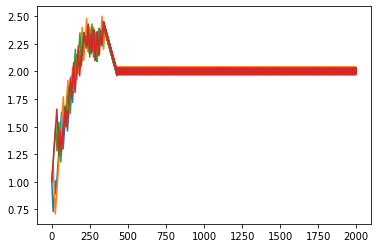

In [98]:
plt.plot(p1.energyplot)
plt.plot(p2.energyplot)
plt.plot(p3.energyplot)
plt.plot(p4.energyplot)
plt.show()

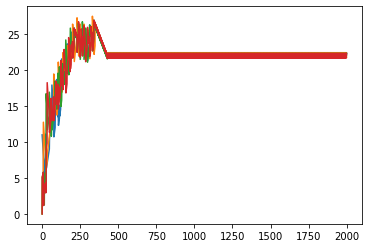

In [99]:
plt.plot(p1.scoreplot)
plt.plot(p2.scoreplot)
plt.plot(p3.scoreplot)
plt.plot(p4.scoreplot)
plt.show()